In [29]:
import numpy as np
import math
from math import sin, cos, tan
from numpy import matmul as mm  # Matrix multiplication
from numpy import linalg as lg
from matplotlib import pyplot as plt

print('----- Import Finished -----')


----- Import Finished -----


In [30]:
# def sin(o):
#     return math.sin(o)

# def cos(o):
#     return math.cos(o)

# def tan(o):
#     return math.tan(o)


class laminate():
    def __init__(self):
        #super(self).__init__()
        # Bacis parameters of composite
        self.E1f = 120  # Young Modulus of fibers
        self.E2f = 120  # Young Modulus of fibers in 2 direction
        self.Rf = 0.5   # Fiber volume fraction
        self.V12f = 0.22 # Poisson's ratio of fibers
        self.G12f = self.E1f / (2 + 2 * self.V12f) # Shear Modulus of fibers

        self.Em = 8   # Young Modulus of matrix
        self.Vm = 0.28   # Poisson's ratio of matrix
        self.Gm = self.Em / (2 + 2 * self.Vm)  # Shear Modulus of matrix

        self.etaE = (self.E2f - self.Em) / (self.E2f + self.Em)
        self.etaG = (self.G12f - self.Gm) / (self.G12f + self.Gm)



        # Local coordinate system
        self.E11 = self.Rf * self.E1f + (1 - self.Rf) * self.Em                     # Young Modulus in 1
        self.E22 = self.Em * (1 + self.etaE * self.Rf) / (1 - self.etaE * self.Rf)  # Young Modulus in 2
        self.V12 = self.Rf * self.V12f + (1 - self.Rf) * self.Vm                    # Poisson's ratio 21
        self.V21 = (self.V12 * self.E22) / self.E11                                 # Poisson's ratio 12, V21/E11 = V12/E22
        self.G12 = self.Gm * (1 + self.etaG * self.Rf) / (1 - self.etaG * self.Rf)  # Shear modulus of composite

        # parameters of composite
        self.N = 6                                     # number of plys
        self.thickness = 22.8e-3                           # Thickness of the composit
        # self.ply_angle = [self.theta] * self.N                  # angle of each plys
        self.angle = None                              # radian angle
        self.z = None                                  # ply

        # Matrix
        self.S = None          # positive axis compliance matrix
        self.Q = None          # positive-axis modulus matrix
        self.T_stress = None   # stress conversion matrix
        self.T_strain = None   # strain conversion matrix

    def plys(self, theta):
        N = self.N             # number of plies
        t_ply = [self.thickness / self.N] * N  # ply thickness in m
        t_LAM = 0

        for i in range(N):
            t_LAM += t_ply[i]  # laminate thickness in m, 8 multiply by the thinkness of each ply

        # Distance from laminate mid-plane to out surfaces of plies in m
        z = self.z
        z = [0] * (N+1)
        for i in range(N+1):
            z[i] = (-t_LAM / 2) + (i * t_ply[i-1])
        #print(z[1])

        # Distance from laminate mid-plane to mid-planes of plies in m
        z_mid_plane = [0] * N
        for i in range(N):
            z_mid_plane[i] = (-t_LAM / 2) - (t_ply[i]/2) + ((i+1) * t_ply[i])

        # Enter a desired ply orientation angle in degrees here:
        ply_angle = [theta] * self.N

        # Ply orientation angle translated to radians to simplify equations below
        angle = [0] * N
        for i in range(N):
            angle[i] = math.radians(ply_angle[i])

        # Stress Transformation (Global to Local), pg 112
        self.T_stress = [0] * N
        for i in range(N):
            self.T_stress[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, 2*sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
             -2*sin(angle[i])*cos(angle[i])], [-sin(angle[i])*cos(angle[i]), sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        # Strain Transformation (Global-to-Local), pg 113
        self.T_strain = [0] * N
        for i in range(N):
            self.T_strain[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
            -sin(angle[i])*cos(angle[i])], [-2*sin(angle[i])*cos(angle[i]), 2*sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        self.angle = angle
        self.t_ply = t_ply
        self.z = z

        # for i in range(8):
        #     print(self.T_stress[i])
        return self.T_stress, self.T_strain, self.angle, self.t_ply, self.z




    def cal_ABD(self, theta):
        theta = theta

        laminate.plys(self, theta=theta)

        # Parameters of the composite
        E11 = self.E11
        E22 = self.E22
        V21 = self.V21
        V12 = self.V12
        G12 = self.G12

        N = self.N
        t_ply = self.t_ply
        T_stress = self.T_stress
        T_strain = self.T_strain
        z = self.z
        #print('z:', z)

        # The local/lamina compliance matrix
        S11 = 1/E11
        S12 = -V21/E22
        S21 = -V12/E11
        S22 = 1/E22
        S66 = 1/G12
        S16 = S61 = S26 = S62 = 0
        S = np.array([[S11, S12, 0], [S21, S22, 0], [0, 0, S66]])

        # The local/lamina stiffness matrix
        Q_loc = lg.inv(S)  # The inverse of the S matrix
        #print('Q_loc:', Q_loc)

        # The global/laminate stiffness and compliance matrices
        Q_glo = [0.0] * N
        for i in range(N):
            Q_glo[i] = mm(lg.inv(T_stress[i]), mm(Q_loc, T_strain[i]))
        #print('Q_glo；', Q_glo)

        # Calculate the ABD Matrix
        A = [[0.0]*3] * 3
        for i in range(N):
            A += Q_glo[i] * t_ply[i]

        B = [[0.0]*3] * 3
        for i in range(N):
            B += (1 / 2) * (Q_glo[i] * ((z[i + 1]**2) - ((z[i + 1] - t_ply[i])**2)))

        D = [[0.0]*3] * 3
        for i in range(N):
            D += (1/3) * (Q_glo[i] * ((z[i+1] ** 3) - ((z[i+1] - t_ply[i]) ** 3)))

        ABD = np.array([[A[0][0],A[0][1],A[0][2],B[0][0],B[0][1],B[0][2]],
                        [A[1][0],A[1][1],A[1][2],B[1][0],B[1][1],B[1][2]],
                        [A[2][0],A[2][1],A[2][2],B[2][0],B[2][1],B[2][2]],
                        [B[0][0],B[0][1],B[0][2],D[0][0],D[0][1],D[0][2]],
                        [B[1][0],B[1][1],B[1][2],D[1][0],D[1][1],D[1][2]],
                        [B[2][0],B[2][1],B[2][2],D[2][0],D[2][1],D[2][2]]])

        ABD_inv = lg.inv(ABD)

        # Round tiny numbers to zero
        for i in range(3):
            for j in range(3):
                if 0.000000001 > A[i][j] > -0.000000001:
                    A[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > B[i][j] > -0.000000001:
                    B[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > D[i][j] > -0.000000001:
                    D[i][j] = 0

        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD_inv[i][j] > -0.000000001:
                    ABD_inv[i][j] = 0

        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD[i][j] > -0.000000001:
                    ABD[i][j] = 0

        return A, B, D, ABD, ABD_inv


    def Result_print(self, theta):

        laminate.cal_ABD(self, theta=theta)

        # # Printing the A, B and D matrices
        # print("\n[A] matrix:")
        # print('[' + format(A[0][0], '^12.2e') + format(A[0][1], '^12.2e') + format(A[0][2], '^12.2e') + ']')
        # print('[' + format(A[1][0], '^12.2e') + format(A[1][1], '^12.2e') + format(A[1][2], '^12.2e') + ']')
        # print('[' + format(A[2][0], '^12.2e') + format(A[2][1], '^12.2e') + format(A[2][2], '^12.2e') + ']')
        # print("\n[B] matrix:")
        # print('[' + format(B[0][0], '^12.2e') + format(B[0][1], '^12.2e') + format(B[0][2], '^12.2e') + ']')
        # print('[' + format(B[1][0], '^12.2e') + format(B[1][1], '^12.2e') + format(B[1][2], '^12.2e') + ']')
        # print('[' + format(B[2][0], '^12.2e') + format(B[2][1], '^12.2e') + format(B[2][2], '^12.2e') + ']')
        # print("\n[D] matrix:")
        # print('[' + format(D[0][0], '^12.2e') + format(D[0][1], '^12.2e') + format(D[0][2], '^12.2e') + ']')
        # print('[' + format(D[1][0], '^12.2e') + format(D[1][1], '^12.2e') + format(D[1][2], '^12.2e') + ']')
        # print('[' + format(D[2][0], '^12.2e') + format(D[2][1], '^12.2e') + format(D[2][2], '^12.2e') + ']')

        # Printing the [ABD] matrix
        print("\n[ABD] matrix:")
        print('[' + format(ABD[0][0], '^12.2e') + format(ABD[0][1], '^12.2e') + format(ABD[0][2], '^12.2e') + format(ABD[0][3], '^12.2e') + format(ABD[0][4], '^12.2e') + format(ABD[0][5], '^12.2e') + ']')
        print('[' + format(ABD[1][0], '^12.2e') + format(ABD[1][1], '^12.2e') + format(ABD[1][2], '^12.2e') + format(ABD[1][3], '^12.2e') + format(ABD[1][4], '^12.2e') + format(ABD[1][5], '^12.2e') + ']')
        print('[' + format(ABD[2][0], '^12.2e') + format(ABD[2][1], '^12.2e') + format(ABD[2][2], '^12.2e') + format(ABD[2][3], '^12.2e') + format(ABD[2][4], '^12.2e') + format(ABD[2][5], '^12.2e') + ']')
        print('[' + format(ABD[3][0], '^12.2e') + format(ABD[3][1], '^12.2e') + format(ABD[3][2], '^12.2e') + format(ABD[3][3], '^12.2e') + format(ABD[3][4], '^12.2e') + format(ABD[3][5], '^12.2e') + ']')
        print('[' + format(ABD[4][0], '^12.2e') + format(ABD[4][1], '^12.2e') + format(ABD[4][2], '^12.2e') + format(ABD[4][3], '^12.2e') + format(ABD[4][4], '^12.2e') + format(ABD[4][5], '^12.2e') + ']')
        print('[' + format(ABD[5][0], '^12.2e') + format(ABD[5][1], '^12.2e') + format(ABD[5][2], '^12.2e') + format(ABD[5][3], '^12.2e') + format(ABD[5][4], '^12.2e') + format(ABD[5][5], '^12.2e') + ']')


        # Printing the inverse [ABD] matrix
        print("\n[ABD]\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE} matrix")
        print('[' + format(ABD_inv[0][0], '^12.2e') + format(ABD_inv[0][1], '^12.2e') + format(ABD_inv[0][2], '^12.2e') + format(ABD_inv[0][3], '^12.2e') + format(ABD_inv[0][4], '^12.2e') + format(ABD_inv[0][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[1][0], '^12.2e') + format(ABD_inv[1][1], '^12.2e') + format(ABD_inv[1][2], '^12.2e') + format(ABD_inv[1][3], '^12.2e') + format(ABD_inv[1][4], '^12.2e') + format(ABD_inv[1][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[2][0], '^12.2e') + format(ABD_inv[2][1], '^12.2e') + format(ABD_inv[2][2], '^12.2e') + format(ABD_inv[2][3], '^12.2e') + format(ABD_inv[2][4], '^12.2e') + format(ABD_inv[2][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[3][0], '^12.2e') + format(ABD_inv[3][1], '^12.2e') + format(ABD_inv[3][2], '^12.2e') + format(ABD_inv[3][3], '^12.2e') + format(ABD_inv[3][4], '^12.2e') + format(ABD_inv[3][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[4][0], '^12.2e') + format(ABD_inv[4][1], '^12.2e') + format(ABD_inv[4][2], '^12.2e') + format(ABD_inv[4][3], '^12.2e') + format(ABD_inv[4][4], '^12.2e') + format(ABD_inv[4][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[5][0], '^12.2e') + format(ABD_inv[5][1], '^12.2e') + format(ABD_inv[5][2], '^12.2e') + format(ABD_inv[5][3], '^12.2e') + format(ABD_inv[5][4], '^12.2e') + format(ABD_inv[5][5], '^12.2e') + ']')




A, B, D, ABD, ABD_inv = laminate().cal_ABD(theta=1)
#print('ABD: \n', ABD)
# print('ABD_inv: \n', ABD_inv)


# Question 2-a
Show the inverse of the ABD matrix (consider an angle of 0° for the fiber orientation). Which couplings are present? What is the reason for these couplings? 

In [31]:
laminate().Result_print(theta = 0)


[ABD] matrix:
[  1.49e+00    1.19e-01    1.75e-02    0.00e+00    0.00e+00    0.00e+00  ]
[  1.19e-01    4.76e-01    1.79e-04    0.00e+00    0.00e+00    0.00e+00  ]
[  1.75e-02    1.79e-04    1.84e-01    0.00e+00    0.00e+00    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    6.45e-05    5.16e-06    7.58e-07  ]
[  0.00e+00    0.00e+00    0.00e+00    5.16e-06    2.06e-05    7.74e-09  ]
[  0.00e+00    0.00e+00    0.00e+00    7.58e-07    7.74e-09    7.95e-06  ]

[ABD]⁻¹ matrix
[  6.86e-01   -1.72e-01   -6.53e-02    0.00e+00    0.00e+00    0.00e+00  ]
[ -1.72e-01    2.15e+00    1.43e-02    0.00e+00    0.00e+00    0.00e+00  ]
[ -6.53e-02    1.43e-02    5.45e+00    0.00e+00    0.00e+00    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    1.58e+04   -3.97e+03   -1.51e+03  ]
[  0.00e+00    0.00e+00    0.00e+00   -3.97e+03    4.95e+04    3.30e+02  ]
[  0.00e+00    0.00e+00    0.00e+00   -1.51e+03    3.30e+02    1.26e+05  ]


# Qusetion 2-b
Show how different components of the inverse of the ABD matrix change in function of the fiber angle (12 figures). Discuss the results.   
Hint: vary the angle in the range +/- 90 degrees every 1 degree. 

Variation of A in the inverse ABD matrix with θ

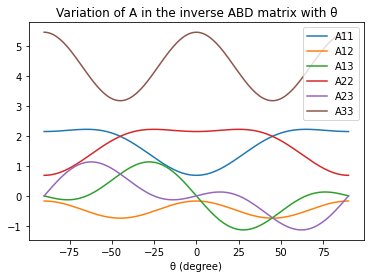

In [32]:
Ainv = [[0] * 181 for _ in range(6)]

X_theta = range(-90, 91, 1)
for i in range (-90, 91):
    A, B, D, ABD, ABD_inv = laminate().cal_ABD(theta=i)
    Ainv[0][i + 90] = ABD_inv[0][0]
    Ainv[1][i + 90] = ABD_inv[0][1]
    Ainv[2][i + 90] = ABD_inv[0][2]
    Ainv[3][i + 90] = ABD_inv[1][1]
    Ainv[4][i + 90] = ABD_inv[1][2]
    Ainv[5][i + 90] = ABD_inv[2][2]


plt.plot(X_theta, Ainv[0], label='A11')
plt.plot(X_theta, Ainv[1], label='A12')
plt.plot(X_theta, Ainv[2], label='A13')
plt.plot(X_theta, Ainv[3], label='A22')
plt.plot(X_theta, Ainv[4], label='A23')
plt.plot(X_theta, Ainv[5], label='A33')
plt.xlabel('θ (degree)')
plt.title('Variation of A in the inverse ABD matrix with θ')

plt.legend()


Variation of D in the inverse ABD matrix with θ

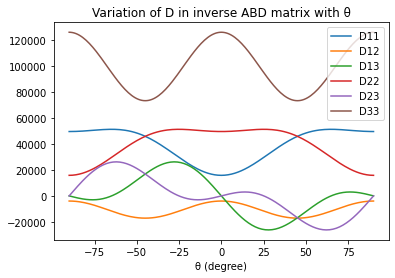

In [33]:
Dinv = [[0] * 181 for _ in range(6)]

X_theta = range(-90, 91, 1)
for i in range(-90, 91):
    A, B, D, ABD, ABD_inv = laminate().cal_ABD(theta=i)
    Dinv[0][i + 90] = ABD_inv[3][3]
    Dinv[1][i + 90] = ABD_inv[3][4]
    Dinv[2][i + 90] = ABD_inv[3][5]
    Dinv[3][i + 90] = ABD_inv[4][4]
    Dinv[4][i + 90] = ABD_inv[4][5]
    Dinv[5][i + 90] = ABD_inv[5][5]

plt.plot(X_theta, Dinv[0], label='D11')
plt.plot(X_theta, Dinv[1], label='D12')
plt.plot(X_theta, Dinv[2], label='D13')
plt.plot(X_theta, Dinv[3], label='D22')
plt.plot(X_theta, Dinv[4], label='D23')
plt.plot(X_theta, Dinv[5], label='D33')
plt.xlabel('θ (degree)')
plt.title('Variation of D in inverse ABD matrix with θ')

plt.legend()

# Question 2-c
Load the plate by 𝑀𝑥𝑥 = 10 𝑘𝑁𝑚/𝑚 and show how all six plate deformations change in function of the fiber angle (6 figures). Discuss the results.  

In [34]:
Loads = np.array([0, 0, 0, 10000, 0, 0])

Deformation = [[0] * 6 for _ in range(181)]

X_theta = range(-90, 91, 1)
for i in range(181):
    A, B, D, ABD, ABD_inv = laminate().cal_ABD(theta=i)
    ABD_inv = np.array(ABD_inv)
    Deformation[i] = mm(ABD_inv, Loads)
Deformation = np.array(Deformation)



Variation of strains with θ

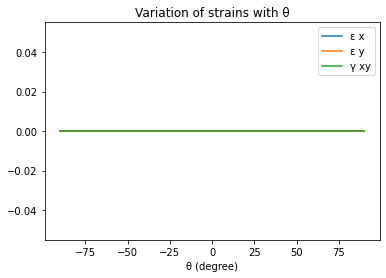

In [35]:
plt.plot(X_theta, Deformation[:, 0], label='ε x')
plt.plot(X_theta, Deformation[:, 1], label='ε y')
plt.plot(X_theta, Deformation[:, 2], label='γ xy')
plt.title('Variation of strains with θ')
plt.xlabel('θ (degree)')
plt.legend()


Variation of curvatures with θ

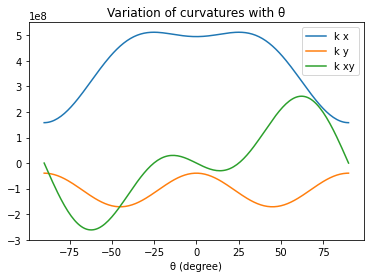

In [36]:
plt.plot(X_theta, Deformation[:, 3], label='k x')
plt.plot(X_theta, Deformation[:, 4], label='k y')
plt.plot(X_theta, Deformation[:, 5], label='k xy')
plt.title('Variation of curvatures with θ')
plt.xlabel('θ (degree)')
plt.legend()

# Question 2-d
Load the plate by 𝑀𝑥𝑦 = 10 𝑘𝑁𝑚/𝑚 and show how all six plate deformations change in function of the fiber angle (6 figures). Discuss the results.   


In [37]:
Loads = np.array([0, 0, 0, 0, 10000, 0])

Deformation = [[0] * 6 for _ in range(181)]

X_theta = range(-90, 91, 1)
for i in range(181):
    A, B, D, ABD, ABD_inv = laminate().cal_ABD(theta=i)
    ABD_inv = np.array(ABD_inv)
    Deformation[i] = mm(ABD_inv, Loads)
Deformation = np.array(Deformation)

Variation of strains with θ

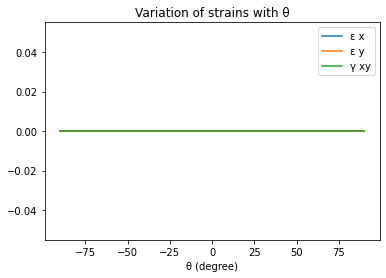

In [38]:
plt.plot(X_theta, Deformation[:, 0], label='ε x')
plt.plot(X_theta, Deformation[:, 1], label='ε y')
plt.plot(X_theta, Deformation[:, 2], label='γ xy')
plt.title('Variation of strains with θ')
plt.xlabel('θ (degree)')
plt.legend()

Variation of curvatures with θ

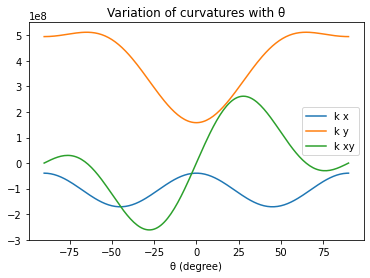

In [39]:
plt.plot(X_theta, Deformation[:, 3], label='k x')
plt.plot(X_theta, Deformation[:, 4], label='k y')
plt.plot(X_theta, Deformation[:, 5], label='k xy')
plt.title('Variation of curvatures with θ')
plt.xlabel('θ (degree)')
plt.legend()

# Question 2-e
Load the plate by 𝑀𝑥𝑥 = 𝑀𝑥𝑦 = 10 𝑘𝑁𝑚/𝑚 and show how all six plate deformations change  in  function  of  the  fiber  angle  (6  figures).  Discuss  the  results.  Are  the  results superposition of results from c and d?   
 


In [40]:
Loads = np.array([0, 0, 0, 10000, 0, 10000])

Deformation = [[0] * 6 for _ in range(181)]

X_theta = range(-90, 91, 1)
for i in range(181):
    A, B, D, ABD, ABD_inv = laminate().cal_ABD(theta=i)
    ABD_inv = np.array(ABD_inv)
    Deformation[i] = mm(ABD_inv, Loads)
Deformation = np.array(Deformation)

Variation of strains with θ

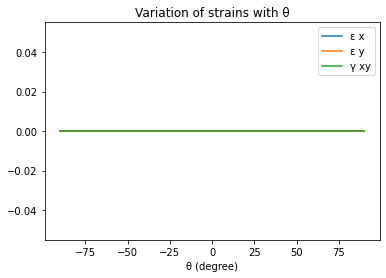

In [41]:
plt.plot(X_theta, Deformation[:, 0], label='ε x')
plt.plot(X_theta, Deformation[:, 1], label='ε y')
plt.plot(X_theta, Deformation[:, 2], label='γ xy')
plt.title('Variation of strains with θ')
plt.xlabel('θ (degree)')
plt.legend()

Variation of curvatures with θ

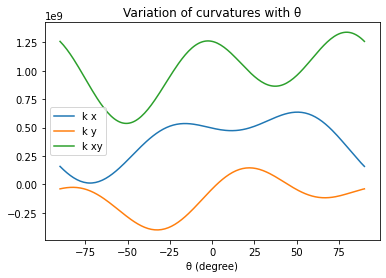

In [42]:
plt.plot(X_theta, Deformation[:, 3], label='k x')
plt.plot(X_theta, Deformation[:, 4], label='k y')
plt.plot(X_theta, Deformation[:, 5], label='k xy')
plt.title('Variation of curvatures with θ')
plt.xlabel('θ (degree)')
plt.legend()